In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf

In [2]:
labels_df = pd.read_csv('isic_balanced_dataset/updated_labels.csv')

image_dir = 'isic_balanced_dataset/processed_images'

def load_image(image_id, image_dir):
    image_path = os.path.join(image_dir, f"{image_id}.jpg")
    image = Image.open(image_path)
    return np.array(image)

images = []
labels = []

for _, row in labels_df.iterrows():
    image_id = row['isic_id']
    label = row['target']
    image = load_image(image_id, image_dir)
    images.append(image)
    labels.append(label)

print(f"Loaded {len(images)} images with {len(labels)} labels.")

Loaded 2179 images with 2179 labels.


In [3]:
images = np.array(images)
labels = np.array(labels)

In [4]:
def labels2text(label):
    return "Benign" if label==0 else "Malignant"

In [5]:
import matplotlib.pyplot as plt

def show_image(image, index):
    plt.imshow(image)
    plt.axis('off')
    plt.title(labels2text(labels[index]))
    plt.show()

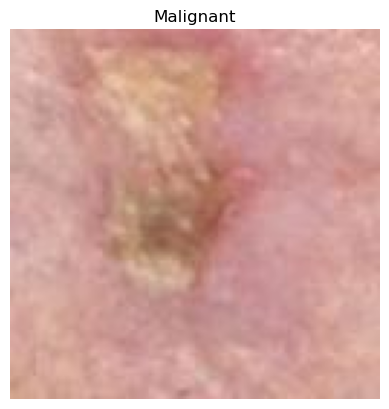

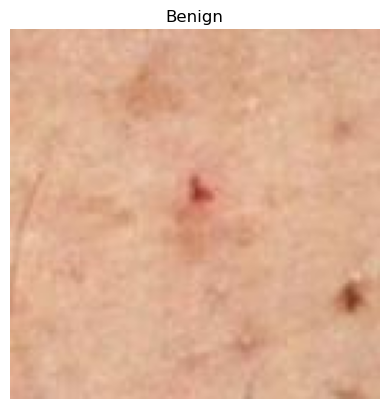

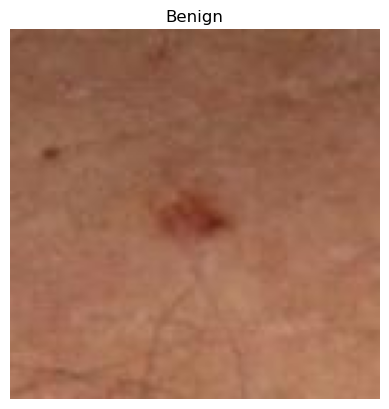

In [6]:
for i in range(3):
    show_image(images[i], i)

In [7]:
def normalize(image):
    image = image / 255.0
    return image

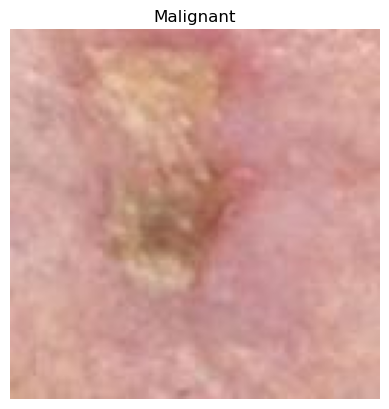

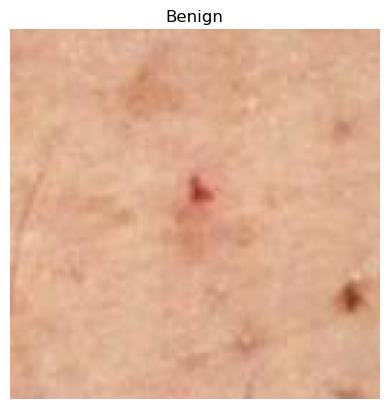

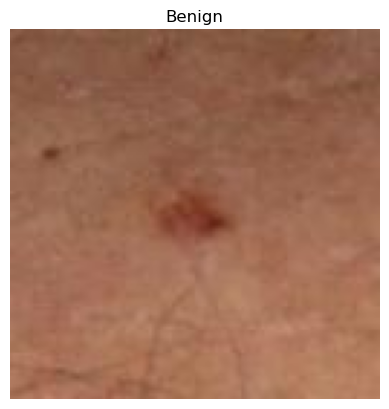

In [8]:
for i in range(3):
    normalized_image = normalize(images[i])
    show_image(normalized_image, i)

In [9]:
X = images.copy()
y = labels.copy()

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1743
Validation set size: 218
Test set size: 218


### Applying Xception

In [11]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top = False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [12]:
X_train_normalized = normalize(X_train)
X_valid_normalized = normalize(X_valid)

In [13]:
def get_loss_fn():
    return tf.keras.losses.binary_crossentropy

In [14]:
def get_optimizer():
    return tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

In [15]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          
    patience=5,                
    restore_best_weights=True  
)

In [16]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss= get_loss_fn(), optimizer=get_optimizer(), metrics=["accuracy"])

history = model.fit(
    X_train_normalized, y_train, 
    validation_data=(X_valid_normalized, y_valid),
    callbacks=[early_stopping_cb],
    batch_size=8,
    epochs=15
)

Epoch 1/15


2024-08-03 05:58:40.624685: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 342687744 exceeds 10% of free system memory.


218/218 [==============================] - 25s 108ms/step - loss: 0.6904 - accuracy: 0.8267 - val_loss: 1.0127 - val_accuracy: 0.8532
Epoch 2/15
218/218 [==============================] - 23s 106ms/step - loss: 0.6565 - accuracy: 0.8491 - val_loss: 1.0538 - val_accuracy: 0.8394
Epoch 3/15
218/218 [==============================] - 23s 106ms/step - loss: 0.5013 - accuracy: 0.8715 - val_loss: 0.8543 - val_accuracy: 0.8440
Epoch 4/15
218/218 [==============================] - 24s 109ms/step - loss: 0.3337 - accuracy: 0.8979 - val_loss: 0.8399 - val_accuracy: 0.8532
Epoch 5/15
218/218 [==============================] - 24s 112ms/step - loss: 0.2752 - accuracy: 0.9002 - val_loss: 1.0597 - val_accuracy: 0.8211
Epoch 6/15
218/218 [==============================] - 24s 111ms/step - loss: 0.3745 - accuracy: 0.8910 - val_loss: 0.8033 - val_accuracy: 0.8486
Epoch 7/15
218/218 [==============================] - 25s 113ms/step - loss: 0.1870 - accuracy: 0.9277 - val_loss: 0.7953 - val_accuracy: 0.8

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

